# Import

In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 130kB/s 
     |████████████████████████████████| 6.8MB 54.7MB/s 
     |████████████████████████████████| 983kB 55.4MB/s 
     |████████████████████████████████| 266kB 48.7MB/s 
     |████████████████████████████████| 1.9MB 45.6MB/s 
     |████████████████████████████████| 1.2MB 45.3MB/s 
     |████████████████████████████████| 471kB 50.8MB/s 
     |████████████████████████████████| 3.3MB 40.4MB/s 
     |████████████████████████████████| 901kB 47.5MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.2-cp37-none-any.whl size=25277794 sha256=43462542b70733160ea5937bdbdc1e26d6035a02e4ded010126768c98e75819a
  Stored in directory: /root/.cache/pip/wheels/67/2e/f1/c72afa08df8b2d984b910dea228902ce81dae4511afe9fafd2
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=cfdcc82bdf2a0ef4c41680be640a9c101a268365b2b913c685f8ad7e74415130
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import ktrain
from ktrain import text

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/datasets/train_cleaned.csv')
#train = pd.read_csv('./datasets/train_cleaned.csv')

# Model

In [ ]:
X = train['merged'].values.tolist()
classes = ['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']
y = train[classes].values.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
train_data, test_data, preprocess = text.texts_from_array(x_train=X_train,
                                                          y_train=y_train,
                                                          x_test=X_test,
                                                          y_test=y_test,
                                                          class_names=classes,                                                                                                        
                                                          maxlen=300,                                                
                                                          preprocess_mode='distilbert',
                                                          random_state=42,
                                                          verbose=1,
                                                          )

preprocessing train...
language: en
train sequence lengths:
	mean : 158
	95percentile : 268
	99percentile : 299


Is Multi-Label? True
preprocessing test...
language: en
test sequence lengths:
	mean : 157
	95percentile : 266
	99percentile : 298


task: text classification


In [ ]:
disbert_model = text.text_classifier(name='distilbert',
                                    train_data=train_data,
                                    preproc=preprocess,
                                    metrics=['accuracy']
                                    )
    
learner = ktrain.get_learner(model=disbert_model,
                              train_data=train_data,
                              val_data=test_data,
                              )
    

Is Multi-Label? True
maxlen is 300



done.


In [ ]:
disbert_model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  4614      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,958,086
Trainable params: 66,958,086
Non-trainable params: 0
_________________________________________________________________


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
524/524 [==============================] - 999s 2s/step - loss: 0.6465 - accuracy: 0.3555
Epoch 2/1024
524/524 [==============================] - 985s 2s/step - loss: 0.2473 - accuracy: 0.7254
Epoch 3/1024
524/524 [==============================] - 582s 1s/step - loss: 1.0074 - accuracy: 0.3736


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


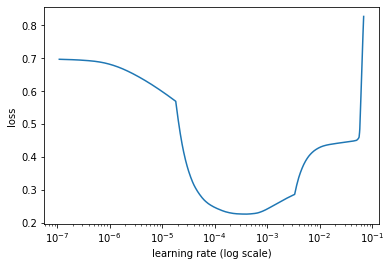

In [ ]:
learner.lr_find()
learner.lr_plot()

In [ ]:
# previously tested that convergence was achieved on 3rd epoch
history = learner.autofit(5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
525/525 [==============================] - 605s 1s/step - loss: 0.3878 - accuracy: 0.6167 - val_loss: 0.1768 - val_accuracy: 0.7638
Epoch 2/1024
525/525 [==============================] - 598s 1s/step - loss: 0.1586 - accuracy: 0.7851 - val_loss: 0.1662 - val_accuracy: 0.7549
Epoch 3/1024
525/525 [==============================] - 597s 1s/step - loss: 0.1331 - accuracy: 0.8035 - val_loss: 0.1658 - val_accuracy: 0.7645
Epoch 4/1024
525/525 [==============================] - 598s 1s/step - loss: 0.1081 - accuracy: 0.8243 - val_loss: 0.1765 - val_accuracy: 0.7580
Epoch 5/1024
525/525 [==============================] - 598s 1s/step - loss: 0.0856 - accuracy: 0.8340 - val_loss: 0.1961 - val_accuracy: 0.7490

Epoch 00005: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping

In [ ]:
predictor = ktrain.get_predictor(learner.model, preprocess)

In [ ]:
filepath='/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/distilBERT'
predictor.save(filepath)

In [ ]:
# load saved model to skip training
filepath='/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/distilBERT'
predictor = ktrain.load_predictor(filepath)


In [ ]:
# code snippet adapted from 'https://github.com/adam0ling/twitter_sentiment'

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='train acc')
    plt.plot(x, val_acc, 'r', label='val acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='train loss')
    plt.plot(x, val_loss, 'r', label='val loss')
    plt.title('Loss')
    plt.legend()

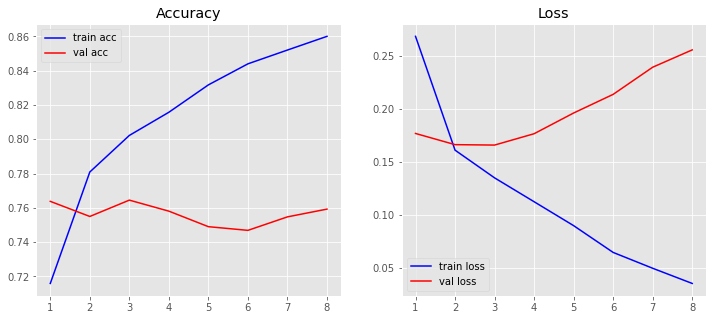

In [ ]:
plot_history(history)

In [ ]:
%%timeit -r1 -n1
y_pred = predictor.predict(X_test)

1 loop, best of 1: 54.3 s per loop


In [ ]:
y_pred = predictor.predict(X_test)

In [ ]:
y_pred[0]

[('Computer Science', 0.91387224),
 ('Physics', 0.0071514375),
 ('Mathematics', 0.004550745),
 ('Statistics', 0.47940552),
 ('Quantitative Biology', 0.009049396),
 ('Quantitative Finance', 0.0013973576)]

In [ ]:
# extract probability from each tuple and round off to get prediction as integer
temp = []
for row in y_pred:
    arr = []
    for tup in row:
      arr.append(tup[1])
    temp.append(arr)  

y_pred = np.array(temp).round().astype(int)

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes, digits=3))
print('hamming loss : {} \n'.format(hamming_loss(y_test, y_pred)))

                      precision    recall  f1-score   support

    Computer Science      0.819     0.884     0.850      1692
             Physics      0.911     0.874     0.892      1226
         Mathematics      0.852     0.774     0.811      1150
          Statistics      0.776     0.809     0.792      1069
Quantitative Biology      0.602     0.557     0.579       122
Quantitative Finance      0.889     0.711     0.790        45

           micro avg      0.833     0.834     0.833      5304
           macro avg      0.808     0.768     0.786      5304
        weighted avg      0.835     0.834     0.833      5304
         samples avg      0.860     0.869     0.845      5304

hamming loss : 0.07024235200635677 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_test = np.array(y_test)
#check for number of labels in test data.
print('Test Set:')
for i in range(4):
    n_labels = y_test_arr[y_test_arr.sum(axis=1)==i].shape[0]
    print('There are {} texts with {} label(s).'.format(n_labels, i))

Test Set:
There are 0 texts with 0 label(s).
There are 3141 texts with 1 label(s).
There are 999 texts with 2 label(s).
There are 55 texts with 3 label(s).


In [ ]:
#check for number of labels in test data.
print('Prediction:')
for i in range(4):
    n_labels = y_pred[y_pred.sum(axis=1)==i].shape[0]
    print('There are {} texts with {} label(s).'.format(n_labels, i))

Prediction:
There are 20 texts with 0 label(s).
There are 3051 texts with 1 label(s).
There are 1115 texts with 2 label(s).
There are 9 texts with 3 label(s).


The model did not produce any predicted label for 20 texts.

# Model Evaluation



| library | model                                      |     type    | micro F1 | hamming loss | classes with nil prediction | lowest recall |
|---------|--------------------------------------------|:-----------:|:--------:|:------------:|:---------------------------:|:-------------:|
| sklearn | logistic regression                        | one vs rest |   0.799  |    0.0709    |              0              |     0.041     |
| sklearn | support vector machine                     | one vs rest |   0.811  |    0.0756    |              0              |     0.016     |
| keras   | simple neural network without word vectors |  multilabel |   0.798  |    0.0825    |              2              |     0.000     |
| keras   | simple RNN with LexVec                     |  multilabel |   0.677  |    0.1205    |              3              |     0.000     |
| keras   | LSTM and GRU with LexVec                   |  multilabel |   0.807  |    0.0776    |              0              |     0.066     |
| ktrain  | biGRU                                      |  multilabel |   0.82   |    0.0733    |              0              |     0.356     |
| ktrain  | BERT                                       |  multilabel |   0.825  |    0.0729    |              0              |     0.352     |
| ktrain  | distilBERT                                 |  multilabel |   0.833  |    0.0702    |              0              |     0.557     |

The first two models from Sklearn are not true multilabel models and will not scale well if higher numebr of labels. Hence there was a need to search for more complex models to account for all classes.

In my early attempts to understand and to build neural networks, I began with architects with lower complexities. However they often turn up nil predictions for the minority class. Even though the micro F1 score did not vary much, it can be a misleading metric. It is prudent to always examine the scores for individual classes from classification reports. 

Only the last 3 ktrain prebuilt models worked well enough to serve as proper multilabel models that takes all labels into account. On the flipside, all 3 require loading of pretrained models which are of about 1 Gb each and it became necessary to separate into individual Colab notebooks.

**Final Model Selection: distilBERT**





The best performing model is distillBERT which produced the highest micro F1 and lowest hamming loss. Also the lowest recall among 6 classes is 0.557 for the most poorly classified Quantitative Biology class, which is a marked improvement over all other models. 

While BERT produced decent results, the pretrained model was large in size and max length of text was capped at 128 due to memory constraint of Colab GPU. Also the saved model is about 1.3 GB in size. 

By contrast, there was no constraint in max length when implementing distilBERT so no text was truncated. The saved model is much smaller at about 250 MB. 

The models have similar training times with 2/3 epochs of about 10 minutes each. The convergence was remarkablely fast compared to other simpler neural network architectures. 

However there remains 20 out of 4195 unclassified articles. I began with 357 unclassified articles for the benchmark Logistic Regression model. 

With this model, I examine the misclassified articles for any reason of poor prediction. Subsequently, predictions will be generated with this model for submission to the Analytics Vidhya hackathon.


# Evaluation of Misclassified Articles


In [ ]:
learner.view_top_losses(n=3, preproc=preprocess)

----------
id:1667 | loss:2.26 | true:[0. 0. 0. 0. 1. 1.] | pred:[0.18 0.57 0.7  0.01 0.   0.  ])

----------
id:887 | loss:1.96 | true:[1. 0. 0. 0. 0. 0.] | pred:[0. 1. 0. 0. 0. 0.])

----------
id:1003 | loss:1.89 | true:[0. 0. 1. 1. 0. 0.] | pred:[0.98 0.01 0.1  0.01 0.   0.  ])



Unfortunately, I am not able to pinpoint which articles they are. The ground truth labels do not match. 

To work around this, I retrieve the predictions with the highest individual hamming loss.

In [ ]:
hamming_list = []
for x,y in zip(y_test, y_pred):
  hamming = hamming_loss(x,y)
  hamming_list.append(hamming)

In [ ]:
validation_df = pd.DataFrame({'text': X_test, 'hamming loss' : hamming_list})

In [ ]:
# Top 5 hamming losses
validation_df.sort_values(by='hamming loss', ascending=False).head()

,text,hamming loss
3614,Efficient and consistent inference of ancestra...,0.666667
1488,Cyclic Dominance in the Spatial Coevolutionary...,0.666667
1667,Particle-without-Particle: a practical pseudos...,0.666667
3914,Multiscale Information Decomposition: Exact Co...,0.500000
336,SMAGEXP: a galaxy tool suite for transcriptomi...,0.500000


In [ ]:
# custom function to display text and the associated ground truth and prediction
def examine_article(num):
  
    article = validation_df.loc[num,'text']
    str_segment = article[:50]
    print('text: {}'.format(article))

    # retrieve ground truth from train set by searching for str_segment
    idx = train[train['merged'].str.contains(str_segment)].index[0]
    preds = train.loc[idx][classes].values
    ground_truth={}
    for cls, pred in zip(classes, preds):
        ground_truth[cls] = pred
    print('ground truth: {}'.format(ground_truth))

    # retrieve predictions from distiBERT predictor 
    pred_dict = {}
    for tup in predictor.predict(article):
        pred_dict[tup[0]] = int(tup[1].round())
    print('prediction:   {}'.format(pred_dict))

In [ ]:
examine_article(3614)

text: Efficient and consistent inference of ancestral sequences in an evolutionary model with insertions and deletions under dense taxon sampling   In evolutionary biology, the speciation history of living organisms is
represented graphically by a phylogeny, that is, a rooted tree whose leaves
correspond to current species and branchings indicate past speciation events.
Phylogenies are commonly estimated from molecular sequences, such as DNA
sequences, collected from the species of interest. At a high level, the idea
behind this inference is simple: the further apart in the Tree of Life are two
species, the greater is the number of mutations to have accumulated in their
genomes since their most recent common ancestor. In order to obtain accurate
estimates in phylogenetic analyses, it is standard practice to employ
statistical approaches based on stochastic models of sequence evolution on a
tree. For tractability, such models necessarily make simplifying assumptions
about the evolutiona

In [ ]:
examine_article(1488)

text: Cyclic Dominance in the Spatial Coevolutionary Optional Prisoner's Dilemma Game   This paper studies scenarios of cyclic dominance in a coevolutionary spatial
model in which game strategies and links between agents adaptively evolve over
time. The Optional Prisoner's Dilemma (OPD) game is employed. The OPD is an
extended version of the traditional Prisoner's Dilemma where players have a
third option to abstain from playing the game. We adopt an agent-based
simulation approach and use Monte Carlo methods to perform the OPD with
coevolutionary rules. The necessary conditions to break the scenarios of cyclic
dominance are also investigated. This work highlights that cyclic dominance is
essential in the sustenance of biodiversity. Moreover, we also discuss the
importance of a spatial coevolutionary model in maintaining cyclic dominance in
adverse conditions.

ground truth: {'Computer Science': 1, 'Physics': 1, 'Mathematics': 1, 'Statistics': 0, 'Quantitative Biology': 0, 'Quantitativ

In [ ]:
examine_article(1667)

text: Particle-without-Particle: a practical pseudospectral collocation method for linear partial differential equations with distributional sources   Partial differential equations with distributional sources---in particular,
involving (derivatives of) delta distributions---have become increasingly
ubiquitous in numerous areas of physics and applied mathematics. It is often of
considerable interest to obtain numerical solutions for such equations, but any
singular ("particle"-like) source modeling invariably introduces nontrivial
computational obstacles. A common method to circumvent these is through some
form of delta function approximation procedure on the computational grid;
however, this often carries significant limitations on the efficiency of the
numerical convergence rates, or sometimes even the resolvability of the problem
at all.
In this paper, we present an alternative technique for tackling such
equations which avoids the singular behavior entirely: the
"Particle-without-P

Observations: These articles clearly have mislabeled ground truths which resulted in poor prediction. They may potentially affect the entire model. Retraining after removal of these articles will likely help improve accuracy in predicting unseen data. 

# Hackathon Submission

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/datasets/test.csv')
subm = pd.read_csv('/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/datasets/sample_submission.csv')

In [ ]:
df['merged'] = df['TITLE'] + ' ' + df['ABSTRACT']

In [ ]:
df.head()

,ID,TITLE,ABSTRACT,merged
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,Closed-form Marginal Likelihood in Gamma-Poiss...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,Laboratory mid-IR spectra of equilibrated and ...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,Case For Static AMSDU Aggregation in WLANs F...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,The $Gaia$-ESO Survey: the inner disk intermed...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,Witness-Functions versus Interpretation-Functi...


In [ ]:
subm.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,0,0,0
1,20974,0,0,0,0,0,0
2,20975,0,0,0,0,0,0
3,20976,0,0,0,0,0,0
4,20977,0,0,0,0,0,0


In [ ]:
y_pred_subm = predictor.predict(df['merged'].values);

In [ ]:
y_pred_subm[:3]

[[('Computer Science', 0.3733354),
  ('Physics', 0.0034942448),
  ('Mathematics', 0.16036937),
  ('Statistics', 0.9706778),
  ('Quantitative Biology', 0.0028468473),
  ('Quantitative Finance', 0.0025563962)],
 [('Computer Science', 0.0025602097),
  ('Physics', 0.9965984),
  ('Mathematics', 0.0026853522),
  ('Statistics', 0.0030278408),
  ('Quantitative Biology', 0.0013248507),
  ('Quantitative Finance', 0.0007537991)],
 [('Computer Science', 0.9879425),
  ('Physics', 0.0070879566),
  ('Mathematics', 0.04109974),
  ('Statistics', 0.0153756095),
  ('Quantitative Biology', 0.0018576107),
  ('Quantitative Finance', 0.00090467255)]]

In [ ]:
temp = []
for row in y_pred_subm:
    arr = []
    for tup in row:
      arr.append(tup[1])
    temp.append(arr)  

y_pred_subm = np.array(temp).round().astype(int)

In [ ]:
# load predictions in each column of submission datafram
for i, label in enumerate(labels):
    subm[label] = y_pred_subm[:,i]

In [ ]:
subm.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0


In [ ]:
subm.to_csv('/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/datasets/final_submission.csv', index=False)

final submission score: 0.839

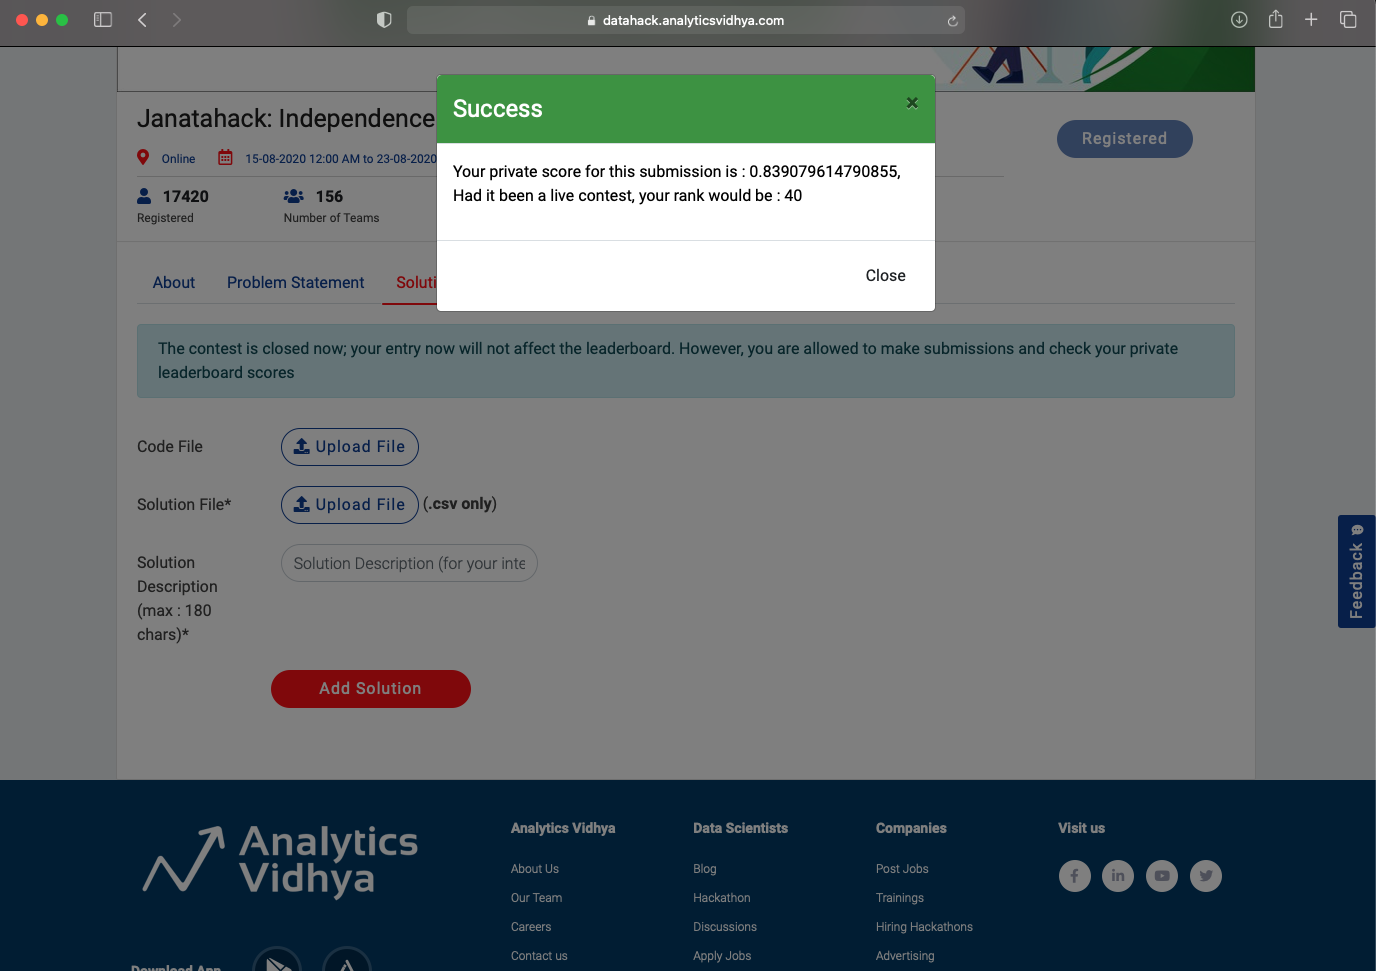